In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder
from scprint.tasks.cell_emb import display_confusion_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
from scdataloader.utils import translate
import bionty as bt
from scprint.tasks.cell_emb import compute_classification

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from scdataloader import SimpleAnnDataset, Collator, DataModule
from torch.utils.data import DataLoader

import lamindb as ln

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


→ connected lamindb: jkobject/scprint_v2


/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/ml4ig1/Documents code/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../1lzuxvg0.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [3]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert


FYI: scPrint is not attached to a `Trainer`.


In [4]:
da = sc.read("./data/task_3_embed.h5ad")

In [5]:
map_to_val = {n: i for i, n in enumerate(set(da.obs["batch"].unique()))}
da.obs["batch"] = da.obs["batch"].map(map_to_val)

In [6]:
# Prepare data for fine-tuning (using the cat/tiger dataset from above)
# Split data into train/val
n_train = int(0.8 * len(da))
train_idx = np.random.choice(len(da), n_train, replace=False)
val_idx = np.setdiff1d(np.arange(len(da)), train_idx)

train_data = da[train_idx].copy()
val_data = da[val_idx].copy()

print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")

mencoders = {}
for k, v in model.label_decoders.items():
    mencoders[k] = {va: ke for ke, va in v.items()}
# this needs to remain its original name as it is expect like that by collator, otherwise need to send org_to_id as params
mencoders.pop("organism_ontology_term_id")

# Create datasets
train_dataset = SimpleAnnDataset(
    train_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

val_dataset = SimpleAnnDataset(
    val_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

# Create collator
collator = Collator(
    organisms=model.organisms,
    valid_genes=model.genes,
    class_names=["cell_type_ontology_term_id", "batch"],
    how="random expr",  # or "all expr" for full expression
    max_len=3000,
    add_zero_genes=0,
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    collate_fn=collator,
    batch_size=32,  # Adjust based on GPU memory
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    collate_fn=collator,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
)

Training data: (21760, 57186)
Validation data: (5440, 57186)


In [7]:
d_model_org = 8
batch_cls = torch.nn.Sequential(
    torch.nn.Linear(d_model_org, d_model_org * 8),
    torch.nn.ReLU(),
    torch.nn.Linear(d_model_org * 8, len(set(da.obs["batch"].unique()))),
)
batch_cls = batch_cls.to(model.device)

In [8]:
for val in model.parameters():
    val.requires_grad = False
    # setting all to TRUE

for val in model.cell_transformer.parameters():
    val.requires_grad = True
# for val in model.transformer.blocks[7].parameters():
#    val.requires_grad = True
for i in model.transformer.blocks:
    i.cross_attn.requires_grad = True
for val in model.compressor.parameters():
    val.requires_grad = True
for val in model.cls_decoders["cell_type_ontology_term_id"].parameters():
    val.requires_grad = True

In [9]:
# Alternative: Manual Training Loop (for more control)
# If you prefer to have more control over the training process
from tqdm import tqdm
import torch.nn.functional as F
from scprint.model import loss

num_epochs = 10
lr = 0.0004

# Setup optimizer
all_params = (
    list(model.parameters()) + list(batch_cls.parameters())
    # + list(batch_vector.parameters())
)
optimizer = torch.optim.AdamW(
    all_params, lr=lr, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-8
)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# Setup automatic mixed precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

_ = model.train()

for k, i in model.mat_labels_hierarchy.items():
    model.mat_labels_hierarchy[k] = i.to(model.device)

/tmp/ipykernel_3506353/1434711341.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [10]:
def mmd_loss(X, Y):
    """
    Compute Maximum Mean Discrepancy (MMD) loss between two 2D embedding matrices.

    Args:
        X: Tensor of shape (n1, emb_dim) - first set of embeddings
        Y: Tensor of shape (n2, emb_dim) - second set of embeddings

    Returns:
        MMD loss value (negative to encourage dissimilarity)
    """

    def rbf_kernel(x, y, sigma):
        """Compute RBF kernel between two sets of vectors"""
        distance = torch.cdist(x, y, p=2) ** 2
        return torch.exp(-distance / (2 * sigma**2))

    # Use multiple kernel bandwidths for better performance
    sigmas = [0.1, 1.0, 10.0]
    mmd_loss = 0.0

    for sigma in sigmas:
        # K(X, X) - kernel matrix within first group (n1 x n1)
        k_xx = rbf_kernel(X, X, sigma)
        # K(Y, Y) - kernel matrix within second group (n2 x n2)
        k_yy = rbf_kernel(Y, Y, sigma)
        # K(X, Y) - kernel matrix between groups (n1 x n2)
        k_xy = rbf_kernel(X, Y, sigma)

        # Unbiased MMD estimation
        n1 = X.shape[0]
        n2 = Y.shape[0]

        # Remove diagonal elements for unbiased estimation of K(X,X) and K(Y,Y)
        # For K(X,X): exclude diagonal
        if n1 > 1:
            mask_xx = 1 - torch.eye(n1, device=X.device)
            k_xx_term = (k_xx * mask_xx).sum() / (n1 * (n1 - 1))
        else:
            k_xx_term = 0.0

        # For K(Y,Y): exclude diagonal
        if n2 > 1:
            mask_yy = 1 - torch.eye(n2, device=Y.device)
            k_yy_term = (k_yy * mask_yy).sum() / (n2 * (n2 - 1))
        else:
            k_yy_term = 0.0

        # For K(X,Y): use all elements (no diagonal to exclude)
        k_xy_term = k_xy.mean()

        # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
        mmd_squared = k_xx_term + k_yy_term - 2 * k_xy_term
        mmd_loss += mmd_squared

    # Return negative MMD to encourage dissimilarity (higher MMD = more different)
    return mmd_loss / len(sigmas)

In [11]:
def batch_corr_pass(batch):
    gene_pos = batch["genes"].to(model.device)
    expression = batch["x"].to(model.device)
    depth = batch["depth"].to(model.device)
    class_elem = batch["class"].long().to(model.device)
    total_loss = 0

    # Forward pass with automatic mixed precisio^n
    with torch.cuda.amp.autocast():
        # Forward pass
        output = model.forward(
            gene_pos,
            expression,
            req_depth=depth,
            depth_mult=expression.sum(1),
            do_class=True,
            metacell_token=torch.zeros_like(depth),
        )
        ## adaptor on ct_emb
        # ctpos = model.classes.index("cell_type_ontology_term_id") + 1
        # emb = output["output_cell_embs"][:, ctpos, :]
        #
        # output["output_cell_embs"][:, ctpos, :] = adaptor_layer(
        #    torch.cat([emb, class_elem[:, 1].unsqueeze(1).float()], dim=1)
        # )

        ## generate expr loss
        output_gen = model._generate(
            cell_embs=output["output_cell_embs"],
            gene_pos=gene_pos,
            depth_mult=expression.sum(1),
            req_depth=depth,
        )
        if "zero_logits" in output_gen:
            loss_expr = loss.zinb(
                theta=output_gen["disp"],
                pi=output_gen["zero_logits"],
                mu=output_gen["mean"],
                target=expression,
            )
            if model.zinb_and_mse:
                loss_expr += (
                    loss.mse(
                        input=torch.log(output_gen["mean"] + 1)
                        * (1 - torch.sigmoid(output_gen["zero_logits"])),
                        target=torch.log(expression + 1),
                    )
                    / 10  # scale to make it more similar to the zinb
                )
        else:
            loss_expr = loss.mse(
                input=torch.log(output_gen["mean"] + 1),
                target=torch.log(expression + 1),
            )
        # Add expression loss to total
        total_loss += loss_expr

        # ct clss
        cls_output = output.get("cls_output_cell_type_ontology_term_id")
        # ct_output = output["output_cell_embs"][:, ctpos, :]
        # cls_output = model.cls_decoders["cell_type_ontology_term_id"](ct_output)
        cls_loss = loss.hierarchical_classification(
            pred=cls_output,
            cl=class_elem[:, 0],
            labels_hierarchy=model.mat_labels_hierarchy.get(
                "cell_type_ontology_term_id"
            ).to("cuda"),
        )
        total_loss += cls_loss

        # organ class
        org_emb = output["compressed_cell_embs"][
            model.classes.index("organism_ontology_term_id") + 1
        ]
        cls_loss = F.cross_entropy(
            input=batch_cls(org_emb),
            target=class_elem[:, 1],
        )
        total_loss += cls_loss

        pos = model.classes.index("cell_type_ontology_term_id") + 1
        # Apply gradient reversal to the input embedding
        selected_emb = (
            output["compressed_cell_embs"][pos]
            if model.compressor is not None
            else output["input_cell_embs"][:, pos, :]
        )
        X, Y = selected_emb[class_elem[:, 1] == 1], selected_emb[class_elem[:, 1] == 0]
        mmd = mmd_loss(X, Y)

        # Add adversarial loss to total loss
        total_loss += mmd if not torch.isnan(mmd) else 0
        total_loss += output["vae_kl_loss"] * 0.5
    return total_loss, cls_loss, mmd, loss_expr

In [12]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Training phase
    train_loss = 0.0
    train_steps = 0
    avg_adv = 0
    avg_expr = 0
    avg_cls = 0

    # pbar = tqdm(train_loader, desc="Training")
    for batch_idx, batch in enumerate(train_loader):
        # if epoch == 0:
        #    break
        # Move batch to device
        optimizer.zero_grad()
        total_loss, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
        # Backward pass
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += total_loss.item()
        train_steps += 1
        avg_cls += cls_loss.item()
        avg_expr += loss_expr.item()
        mmd += mmd.item()
        # Update progress bar
        # if batch_idx % 35 == 0:
        # print(
        #    f"avg_loss {train_loss / train_steps:.4f}, avg_cls {avg_cls / train_steps:.4f}, avg_expr {avg_expr / train_steps:.4f}, avg_adv {avg_adv / train_steps:.4f}"
        # )
        # pbar.set_postfix(
        #    {
        #        "loss": f"{total_loss.item():.4f}",
        #        "avg_loss": f"{train_loss / train_steps:.4f}",
        #        "cls_loss": f"{cls_loss.item():.4f}",
        #        "mmd_loss": f"{mmd.item():.4f}",
        #        "expr_loss": f"{loss_expr.item():.4f}",
        #    }
        # )

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_loss_expr = 0.0
    val_mmd = 0.0
    val_cls = 0.0
    val_loss_to_prt = 0.0

    with torch.no_grad():
        for batch in val_loader:  # tqdm(val_loader, desc="Validation"):
            loss_val, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
            val_loss_to_prt += loss_val.item()
            val_loss += loss_val.item()
            val_steps += 1
            val_loss_expr += loss_expr.item()
            val_mmd += mmd.item()
            val_cls += cls_loss.item()
    try:
        avg_val_loss = val_loss_to_prt / val_steps
        avg_train_loss = train_loss / train_steps
    except ZeroDivisionError:
        print("Error: Division by zero occurred while calculating average losses.")
        avg_train_loss = 0
    print(
        "cls_loss: {:.4f}, mmd_loss: {:.4f}, expr_loss: {:.4f}".format(
            val_cls / val_steps, val_mmd / val_steps, val_loss_expr / val_steps
        )
    )
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Store LR before scheduler step for comparison
    lr_before = optimizer.param_groups[0]["lr"]

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Check if LR was reduced
    lr_after = optimizer.param_groups[0]["lr"]
    if lr_after < lr_before:
        print(
            f"🔻 Learning rate reduced from {lr_before:.2e} to {lr_after:.2e} (factor: {lr_after / lr_before:.3f})"
        )
    else:
        print(f"✅ Learning rate unchanged: {lr_after:.2e}")

    # Early stopping check (simple implementation)
    if epoch > 10 and val_loss / val_steps > 1.3 * avg_train_loss:
        print("Early stopping due to overfitting")
        break

print("Manual fine-tuning completed!")


Epoch 1/10
Current learning rate: 4.00e-04


/tmp/ipykernel_3506353/3017841291.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


cls_loss: 0.0104, mmd_loss: nan, expr_loss: 1.0596
Train Loss: 1.2463, Val Loss: 1.0856
✅ Learning rate unchanged: 4.00e-04

Epoch 2/10
Current learning rate: 4.00e-04


cls_loss: 0.0011, mmd_loss: nan, expr_loss: 1.0563
Train Loss: 1.0677, Val Loss: 1.0673
✅ Learning rate unchanged: 4.00e-04

Epoch 3/10
Current learning rate: 4.00e-04


cls_loss: 0.0005, mmd_loss: nan, expr_loss: 1.0541
Train Loss: 1.0573, Val Loss: 1.0645
✅ Learning rate unchanged: 4.00e-04

Epoch 4/10
Current learning rate: 4.00e-04


cls_loss: 0.0026, mmd_loss: nan, expr_loss: 1.0533
Train Loss: 1.0524, Val Loss: 1.0659
✅ Learning rate unchanged: 4.00e-04

Epoch 5/10
Current learning rate: 4.00e-04


cls_loss: 0.0007, mmd_loss: nan, expr_loss: 1.0511
Train Loss: 1.0494, Val Loss: 1.0604
✅ Learning rate unchanged: 4.00e-04

Epoch 6/10
Current learning rate: 4.00e-04


cls_loss: 0.0002, mmd_loss: nan, expr_loss: 1.0496
Train Loss: 1.0485, Val Loss: 1.0594
✅ Learning rate unchanged: 4.00e-04

Epoch 7/10
Current learning rate: 4.00e-04


cls_loss: 0.0002, mmd_loss: nan, expr_loss: 1.0488
Train Loss: 1.0471, Val Loss: 1.0576
✅ Learning rate unchanged: 4.00e-04

Epoch 8/10
Current learning rate: 4.00e-04


cls_loss: 0.0001, mmd_loss: nan, expr_loss: 1.0464
Train Loss: 1.0440, Val Loss: 1.0550
✅ Learning rate unchanged: 4.00e-04

Epoch 9/10
Current learning rate: 4.00e-04


cls_loss: 0.0001, mmd_loss: nan, expr_loss: 1.0454
Train Loss: 1.0412, Val Loss: 1.0549
✅ Learning rate unchanged: 4.00e-04

Epoch 10/10
Current learning rate: 4.00e-04


cls_loss: 0.0000, mmd_loss: nan, expr_loss: 1.0445
Train Loss: 1.0394, Val Loss: 1.0531
✅ Learning rate unchanged: 4.00e-04
Manual fine-tuning completed!


In [13]:
import lightning as L

checkpoint = {
    "epoch": epoch,
    "global_step": (1 + epoch) * batch_idx,
    "pytorch-lightning_version": L.__version__,
    "state_dict": model.state_dict(),
    "optimizer_states": [optimizer.state_dict()],
    "lr_schedulers": [scheduler.state_dict()],
    "hparams_name": None,
    "loops": None,
    "callbacks": None,
    "hyper_parameters": model.hparams,
}
torch.save(checkpoint, "fit_2.ckpt")

In [14]:
# model.load_state_dict(torch.load("fit_2.ckpt")["state_dict"])

In [15]:
model = scPrint.load_from_checkpoint(
    "fit_2.ckpt", precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert


FYI: scPrint is not attached to a `Trainer`.


In [16]:
da.obs = da.obs.iloc[:, :-15]
for i in [
    "scprint_emb",
    "scprint_emb_age_group",
    "scprint_emb_assay_ontology_term_id",
    "scprint_emb_cell_culture",
    "scprint_emb_cell_type_ontology_term_id",
    "scprint_emb_disease_ontology_term_id",
    "scprint_emb_organism_ontology_term_id",
    "scprint_emb_other",
    "scprint_emb_self_reported_ethnicity_ontology_term_id",
    "scprint_emb_sex_ontology_term_id",
    "scprint_emb_tissue_ontology_term_id",
]:
    da.obsm.pop(i)

In [17]:
embed = Embedder(
    how="random expr",
    max_len=3200,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)

In [18]:
n_adata, metrics = embed(model, da.copy())

not on wandb, could not set name


  0%|                                                                                        | 0/425 [00:00<?, ?it/s]

  0%|▏                                                                               | 1/425 [00:01<10:47,  1.53s/it]

  0%|▍                                                                               | 2/425 [00:01<05:25,  1.30it/s]

  1%|▌                                                                               | 3/425 [00:01<03:41,  1.91it/s]

  1%|▊                                                                               | 4/425 [00:02<02:53,  2.43it/s]

  1%|▉                                                                               | 5/425 [00:02<02:26,  2.86it/s]

  1%|█▏                                                                              | 6/425 [00:02<02:10,  3.20it/s]

  2%|█▎                                                                              | 7/425 [00:02<02:01,  3.45it/s]

  2%|█▌                                                                              | 8/425 [00:03<01:54,  3.65it/s]

  2%|█▋                                                                              | 9/425 [00:03<01:50,  3.77it/s]

  2%|█▊                                                                             | 10/425 [00:03<01:47,  3.88it/s]

  3%|██                                                                             | 11/425 [00:03<01:44,  3.96it/s]

  3%|██▏                                                                            | 12/425 [00:04<01:42,  4.02it/s]

  3%|██▍                                                                            | 13/425 [00:04<01:41,  4.06it/s]

  3%|██▌                                                                            | 14/425 [00:04<01:40,  4.10it/s]

  4%|██▊                                                                            | 15/425 [00:04<01:39,  4.11it/s]

  4%|██▉                                                                            | 16/425 [00:05<01:39,  4.13it/s]

  4%|███▏                                                                           | 17/425 [00:05<01:38,  4.14it/s]

  4%|███▎                                                                           | 18/425 [00:05<01:39,  4.08it/s]

  4%|███▌                                                                           | 19/425 [00:05<01:38,  4.11it/s]

  5%|███▋                                                                           | 20/425 [00:06<01:38,  4.12it/s]

  5%|███▉                                                                           | 21/425 [00:06<01:37,  4.13it/s]

  5%|████                                                                           | 22/425 [00:06<01:37,  4.14it/s]

  5%|████▎                                                                          | 23/425 [00:06<01:37,  4.14it/s]

  6%|████▍                                                                          | 24/425 [00:07<01:36,  4.14it/s]

  6%|████▋                                                                          | 25/425 [00:07<01:36,  4.14it/s]

  6%|████▊                                                                          | 26/425 [00:07<01:36,  4.15it/s]

  6%|█████                                                                          | 27/425 [00:07<01:35,  4.15it/s]

  7%|█████▏                                                                         | 28/425 [00:08<01:35,  4.16it/s]

  7%|█████▍                                                                         | 29/425 [00:08<01:35,  4.15it/s]

  7%|█████▌                                                                         | 30/425 [00:08<01:35,  4.15it/s]

  7%|█████▊                                                                         | 31/425 [00:08<01:35,  4.14it/s]

  8%|█████▉                                                                         | 32/425 [00:08<01:34,  4.14it/s]

  8%|██████▏                                                                        | 33/425 [00:09<01:34,  4.13it/s]

  8%|██████▎                                                                        | 34/425 [00:09<01:34,  4.12it/s]

  8%|██████▌                                                                        | 35/425 [00:09<01:35,  4.09it/s]

  8%|██████▋                                                                        | 36/425 [00:09<01:34,  4.10it/s]

  9%|██████▉                                                                        | 37/425 [00:10<01:34,  4.11it/s]

  9%|███████                                                                        | 38/425 [00:10<01:33,  4.12it/s]

  9%|███████▏                                                                       | 39/425 [00:10<01:33,  4.13it/s]

  9%|███████▍                                                                       | 40/425 [00:10<01:33,  4.13it/s]

 10%|███████▌                                                                       | 41/425 [00:11<01:32,  4.13it/s]

 10%|███████▊                                                                       | 42/425 [00:11<01:32,  4.14it/s]

 10%|███████▉                                                                       | 43/425 [00:11<01:32,  4.15it/s]

 10%|████████▏                                                                      | 44/425 [00:11<01:31,  4.14it/s]

 11%|████████▎                                                                      | 45/425 [00:12<01:32,  4.12it/s]

 11%|████████▌                                                                      | 46/425 [00:12<01:32,  4.11it/s]

 11%|████████▋                                                                      | 47/425 [00:12<01:31,  4.13it/s]

 11%|████████▉                                                                      | 48/425 [00:12<01:31,  4.13it/s]

 12%|█████████                                                                      | 49/425 [00:13<01:30,  4.15it/s]

 12%|█████████▎                                                                     | 50/425 [00:13<01:30,  4.15it/s]

 12%|█████████▍                                                                     | 51/425 [00:13<01:29,  4.16it/s]

 12%|█████████▋                                                                     | 52/425 [00:13<01:29,  4.15it/s]

 12%|█████████▊                                                                     | 53/425 [00:14<01:29,  4.16it/s]

 13%|██████████                                                                     | 54/425 [00:14<01:29,  4.17it/s]

 13%|██████████▏                                                                    | 55/425 [00:14<01:28,  4.17it/s]

 13%|██████████▍                                                                    | 56/425 [00:14<01:28,  4.18it/s]

 13%|██████████▌                                                                    | 57/425 [00:15<01:27,  4.18it/s]

 14%|██████████▊                                                                    | 58/425 [00:15<01:27,  4.19it/s]

 14%|██████████▉                                                                    | 59/425 [00:15<01:27,  4.17it/s]

 14%|███████████▏                                                                   | 60/425 [00:15<01:27,  4.16it/s]

 14%|███████████▎                                                                   | 61/425 [00:15<01:27,  4.17it/s]

 15%|███████████▌                                                                   | 62/425 [00:16<01:27,  4.16it/s]

 15%|███████████▋                                                                   | 63/425 [00:16<01:26,  4.17it/s]

 15%|███████████▉                                                                   | 64/425 [00:16<01:26,  4.16it/s]

 15%|████████████                                                                   | 65/425 [00:16<01:26,  4.15it/s]

 16%|████████████▎                                                                  | 66/425 [00:17<01:27,  4.11it/s]

 16%|████████████▍                                                                  | 67/425 [00:17<01:27,  4.11it/s]

 16%|████████████▋                                                                  | 68/425 [00:17<01:26,  4.12it/s]

 16%|████████████▊                                                                  | 69/425 [00:17<01:26,  4.11it/s]

 16%|█████████████                                                                  | 70/425 [00:18<01:26,  4.12it/s]

 17%|█████████████▏                                                                 | 71/425 [00:18<01:25,  4.12it/s]

 17%|█████████████▍                                                                 | 72/425 [00:18<01:25,  4.13it/s]

 17%|█████████████▌                                                                 | 73/425 [00:18<01:25,  4.14it/s]

 17%|█████████████▊                                                                 | 74/425 [00:19<01:24,  4.16it/s]

 18%|█████████████▉                                                                 | 75/425 [00:19<01:24,  4.16it/s]

 18%|██████████████▏                                                                | 76/425 [00:19<01:23,  4.16it/s]

 18%|██████████████▎                                                                | 77/425 [00:19<01:23,  4.17it/s]

 18%|██████████████▍                                                                | 78/425 [00:20<01:23,  4.17it/s]

 19%|██████████████▋                                                                | 79/425 [00:20<01:22,  4.18it/s]

 19%|██████████████▊                                                                | 80/425 [00:20<01:22,  4.16it/s]

 19%|███████████████                                                                | 81/425 [00:20<01:22,  4.17it/s]

 19%|███████████████▏                                                               | 82/425 [00:21<01:22,  4.16it/s]

 20%|███████████████▍                                                               | 83/425 [00:21<01:21,  4.18it/s]

 20%|███████████████▌                                                               | 84/425 [00:21<01:21,  4.17it/s]

 20%|███████████████▊                                                               | 85/425 [00:21<01:22,  4.15it/s]

 20%|███████████████▉                                                               | 86/425 [00:22<01:21,  4.16it/s]

 20%|████████████████▏                                                              | 87/425 [00:22<01:21,  4.14it/s]

 21%|████████████████▎                                                              | 88/425 [00:22<01:21,  4.15it/s]

 21%|████████████████▌                                                              | 89/425 [00:22<01:20,  4.15it/s]

 21%|████████████████▋                                                              | 90/425 [00:22<01:20,  4.16it/s]

 21%|████████████████▉                                                              | 91/425 [00:23<01:20,  4.16it/s]

 22%|█████████████████                                                              | 92/425 [00:23<01:20,  4.16it/s]

 22%|█████████████████▎                                                             | 93/425 [00:23<01:20,  4.15it/s]

 22%|█████████████████▍                                                             | 94/425 [00:23<01:19,  4.14it/s]

 22%|█████████████████▋                                                             | 95/425 [00:24<01:19,  4.15it/s]

 23%|█████████████████▊                                                             | 96/425 [00:24<01:19,  4.16it/s]

 23%|██████████████████                                                             | 97/425 [00:24<01:18,  4.16it/s]

 23%|██████████████████▏                                                            | 98/425 [00:24<01:18,  4.15it/s]

 23%|██████████████████▍                                                            | 99/425 [00:25<01:18,  4.16it/s]

 24%|██████████████████▎                                                           | 100/425 [00:25<01:18,  4.14it/s]

 24%|██████████████████▌                                                           | 101/425 [00:25<01:18,  4.15it/s]

 24%|██████████████████▋                                                           | 102/425 [00:25<01:17,  4.14it/s]

 24%|██████████████████▉                                                           | 103/425 [00:26<01:17,  4.14it/s]

 24%|███████████████████                                                           | 104/425 [00:26<01:17,  4.15it/s]

 25%|███████████████████▎                                                          | 105/425 [00:26<01:16,  4.16it/s]

 25%|███████████████████▍                                                          | 106/425 [00:26<01:16,  4.15it/s]

 25%|███████████████████▋                                                          | 107/425 [00:27<01:16,  4.16it/s]

 25%|███████████████████▊                                                          | 108/425 [00:27<01:16,  4.15it/s]

 26%|████████████████████                                                          | 109/425 [00:27<01:16,  4.16it/s]

 26%|████████████████████▏                                                         | 110/425 [00:27<01:15,  4.16it/s]

 26%|████████████████████▎                                                         | 111/425 [00:28<01:15,  4.14it/s]

 26%|████████████████████▌                                                         | 112/425 [00:28<01:15,  4.13it/s]

 27%|████████████████████▋                                                         | 113/425 [00:28<01:15,  4.13it/s]

 27%|████████████████████▉                                                         | 114/425 [00:28<01:15,  4.13it/s]

 27%|█████████████████████                                                         | 115/425 [00:29<01:15,  4.11it/s]

 27%|█████████████████████▎                                                        | 116/425 [00:29<01:14,  4.13it/s]

 28%|█████████████████████▍                                                        | 117/425 [00:29<01:14,  4.11it/s]

 28%|█████████████████████▋                                                        | 118/425 [00:29<01:14,  4.13it/s]

 28%|█████████████████████▊                                                        | 119/425 [00:29<01:14,  4.13it/s]

 28%|██████████████████████                                                        | 120/425 [00:30<01:14,  4.11it/s]

 28%|██████████████████████▏                                                       | 121/425 [00:30<01:13,  4.12it/s]

 29%|██████████████████████▍                                                       | 122/425 [00:30<01:12,  4.15it/s]

 29%|██████████████████████▌                                                       | 123/425 [00:30<01:12,  4.15it/s]

 29%|██████████████████████▊                                                       | 124/425 [00:31<01:12,  4.16it/s]

 29%|██████████████████████▉                                                       | 125/425 [00:31<01:12,  4.16it/s]

 30%|███████████████████████                                                       | 126/425 [00:31<01:12,  4.15it/s]

 30%|███████████████████████▎                                                      | 127/425 [00:31<01:12,  4.13it/s]

 30%|███████████████████████▍                                                      | 128/425 [00:32<01:12,  4.10it/s]

 30%|███████████████████████▋                                                      | 129/425 [00:32<01:12,  4.10it/s]

 31%|███████████████████████▊                                                      | 130/425 [00:32<01:11,  4.10it/s]

 31%|████████████████████████                                                      | 131/425 [00:32<01:11,  4.10it/s]

 31%|████████████████████████▏                                                     | 132/425 [00:33<01:11,  4.10it/s]

 31%|████████████████████████▍                                                     | 133/425 [00:33<01:11,  4.10it/s]

 32%|████████████████████████▌                                                     | 134/425 [00:33<01:10,  4.11it/s]

 32%|████████████████████████▊                                                     | 135/425 [00:33<01:11,  4.08it/s]

 32%|████████████████████████▉                                                     | 136/425 [00:34<01:10,  4.08it/s]

 32%|█████████████████████████▏                                                    | 137/425 [00:34<01:10,  4.08it/s]

 32%|█████████████████████████▎                                                    | 138/425 [00:34<01:10,  4.09it/s]

 33%|█████████████████████████▌                                                    | 139/425 [00:34<01:09,  4.09it/s]

 33%|█████████████████████████▋                                                    | 140/425 [00:35<01:09,  4.09it/s]

 33%|█████████████████████████▉                                                    | 141/425 [00:35<01:09,  4.09it/s]

 33%|██████████████████████████                                                    | 142/425 [00:35<01:09,  4.08it/s]

 34%|██████████████████████████▏                                                   | 143/425 [00:35<01:09,  4.08it/s]

 34%|██████████████████████████▍                                                   | 144/425 [00:36<01:09,  4.07it/s]

 34%|██████████████████████████▌                                                   | 145/425 [00:36<01:08,  4.06it/s]

 34%|██████████████████████████▊                                                   | 146/425 [00:36<01:08,  4.06it/s]

 35%|██████████████████████████▉                                                   | 147/425 [00:36<01:08,  4.06it/s]

 35%|███████████████████████████▏                                                  | 148/425 [00:37<01:08,  4.07it/s]

 35%|███████████████████████████▎                                                  | 149/425 [00:37<01:07,  4.08it/s]

 35%|███████████████████████████▌                                                  | 150/425 [00:37<01:07,  4.08it/s]

 36%|███████████████████████████▋                                                  | 151/425 [00:37<01:06,  4.09it/s]

 36%|███████████████████████████▉                                                  | 152/425 [00:38<01:06,  4.09it/s]

 36%|████████████████████████████                                                  | 153/425 [00:38<01:06,  4.08it/s]

 36%|████████████████████████████▎                                                 | 154/425 [00:38<01:06,  4.09it/s]

 36%|████████████████████████████▍                                                 | 155/425 [00:38<01:06,  4.08it/s]

 37%|████████████████████████████▋                                                 | 156/425 [00:39<01:05,  4.10it/s]

 37%|████████████████████████████▊                                                 | 157/425 [00:39<01:05,  4.12it/s]

 37%|████████████████████████████▉                                                 | 158/425 [00:39<01:04,  4.12it/s]

 37%|█████████████████████████████▏                                                | 159/425 [00:39<01:04,  4.13it/s]

 38%|█████████████████████████████▎                                                | 160/425 [00:39<01:04,  4.14it/s]

 38%|█████████████████████████████▌                                                | 161/425 [00:40<01:03,  4.15it/s]

 38%|█████████████████████████████▋                                                | 162/425 [00:40<01:03,  4.15it/s]

 38%|█████████████████████████████▉                                                | 163/425 [00:40<01:03,  4.15it/s]

 39%|██████████████████████████████                                                | 164/425 [00:40<01:02,  4.16it/s]

 39%|██████████████████████████████▎                                               | 165/425 [00:41<01:02,  4.16it/s]

 39%|██████████████████████████████▍                                               | 166/425 [00:41<01:02,  4.16it/s]

 39%|██████████████████████████████▋                                               | 167/425 [00:41<01:02,  4.16it/s]

 40%|██████████████████████████████▊                                               | 168/425 [00:41<01:02,  4.14it/s]

 40%|███████████████████████████████                                               | 169/425 [00:42<01:01,  4.15it/s]

 40%|███████████████████████████████▏                                              | 170/425 [00:42<01:01,  4.15it/s]

 40%|███████████████████████████████▍                                              | 171/425 [00:42<01:01,  4.15it/s]

 40%|███████████████████████████████▌                                              | 172/425 [00:42<01:01,  4.14it/s]

 41%|███████████████████████████████▊                                              | 173/425 [00:43<01:00,  4.13it/s]

 41%|███████████████████████████████▉                                              | 174/425 [00:43<01:00,  4.12it/s]

 41%|████████████████████████████████                                              | 175/425 [00:43<01:00,  4.12it/s]

 41%|████████████████████████████████▎                                             | 176/425 [00:43<01:00,  4.08it/s]

 42%|████████████████████████████████▍                                             | 177/425 [00:44<01:00,  4.09it/s]

 42%|████████████████████████████████▋                                             | 178/425 [00:44<01:00,  4.08it/s]

 42%|████████████████████████████████▊                                             | 179/425 [00:44<01:00,  4.09it/s]

 42%|█████████████████████████████████                                             | 180/425 [00:44<01:00,  4.08it/s]

 43%|█████████████████████████████████▏                                            | 181/425 [00:45<00:59,  4.07it/s]

 43%|█████████████████████████████████▍                                            | 182/425 [00:45<00:59,  4.08it/s]

 43%|█████████████████████████████████▌                                            | 183/425 [00:45<00:59,  4.08it/s]

 43%|█████████████████████████████████▊                                            | 184/425 [00:45<00:58,  4.09it/s]

 44%|█████████████████████████████████▉                                            | 185/425 [00:46<00:58,  4.09it/s]

 44%|██████████████████████████████████▏                                           | 186/425 [00:46<00:58,  4.10it/s]

 44%|██████████████████████████████████▎                                           | 187/425 [00:46<00:57,  4.10it/s]

 44%|██████████████████████████████████▌                                           | 188/425 [00:46<00:57,  4.11it/s]

 44%|██████████████████████████████████▋                                           | 189/425 [00:47<00:57,  4.11it/s]

 45%|██████████████████████████████████▊                                           | 190/425 [00:47<00:57,  4.11it/s]

 45%|███████████████████████████████████                                           | 191/425 [00:47<00:56,  4.12it/s]

 45%|███████████████████████████████████▏                                          | 192/425 [00:47<00:56,  4.11it/s]

 45%|███████████████████████████████████▍                                          | 193/425 [00:47<00:56,  4.10it/s]

 46%|███████████████████████████████████▌                                          | 194/425 [00:48<00:56,  4.10it/s]

 46%|███████████████████████████████████▊                                          | 195/425 [00:48<00:56,  4.09it/s]

 46%|███████████████████████████████████▉                                          | 196/425 [00:48<00:55,  4.09it/s]

 46%|████████████████████████████████████▏                                         | 197/425 [00:48<00:55,  4.09it/s]

 47%|████████████████████████████████████▎                                         | 198/425 [00:49<00:55,  4.10it/s]

 47%|████████████████████████████████████▌                                         | 199/425 [00:49<00:55,  4.09it/s]

 47%|████████████████████████████████████▋                                         | 200/425 [00:49<00:55,  4.07it/s]

 47%|████████████████████████████████████▉                                         | 201/425 [00:49<00:55,  4.07it/s]

 48%|█████████████████████████████████████                                         | 202/425 [00:50<00:54,  4.08it/s]

 48%|█████████████████████████████████████▎                                        | 203/425 [00:50<00:54,  4.08it/s]

 48%|█████████████████████████████████████▍                                        | 204/425 [00:50<00:54,  4.08it/s]

 48%|█████████████████████████████████████▌                                        | 205/425 [00:50<00:54,  4.07it/s]

 48%|█████████████████████████████████████▊                                        | 206/425 [00:51<00:53,  4.07it/s]

 49%|█████████████████████████████████████▉                                        | 207/425 [00:51<00:53,  4.07it/s]

 49%|██████████████████████████████████████▏                                       | 208/425 [00:51<00:53,  4.08it/s]

 49%|██████████████████████████████████████▎                                       | 209/425 [00:51<00:52,  4.09it/s]

 49%|██████████████████████████████████████▌                                       | 210/425 [00:52<00:52,  4.09it/s]

 50%|██████████████████████████████████████▋                                       | 211/425 [00:52<00:52,  4.08it/s]

 50%|██████████████████████████████████████▉                                       | 212/425 [00:52<00:52,  4.07it/s]

 50%|███████████████████████████████████████                                       | 213/425 [00:52<00:52,  4.07it/s]

 50%|███████████████████████████████████████▎                                      | 214/425 [00:53<00:51,  4.06it/s]

 51%|███████████████████████████████████████▍                                      | 215/425 [00:53<00:51,  4.07it/s]

 51%|███████████████████████████████████████▋                                      | 216/425 [00:53<00:51,  4.07it/s]

 51%|███████████████████████████████████████▊                                      | 217/425 [00:53<00:51,  4.06it/s]

 51%|████████████████████████████████████████                                      | 218/425 [00:54<00:50,  4.06it/s]

 52%|████████████████████████████████████████▏                                     | 219/425 [00:54<00:50,  4.06it/s]

 52%|████████████████████████████████████████▍                                     | 220/425 [00:54<00:50,  4.06it/s]

 52%|████████████████████████████████████████▌                                     | 221/425 [00:54<00:50,  4.06it/s]

 52%|████████████████████████████████████████▋                                     | 222/425 [00:55<00:49,  4.07it/s]

 52%|████████████████████████████████████████▉                                     | 223/425 [00:55<00:49,  4.08it/s]

 53%|█████████████████████████████████████████                                     | 224/425 [00:55<00:49,  4.09it/s]

 53%|█████████████████████████████████████████▎                                    | 225/425 [00:55<00:48,  4.09it/s]

 53%|█████████████████████████████████████████▍                                    | 226/425 [00:56<00:48,  4.09it/s]

 53%|█████████████████████████████████████████▋                                    | 227/425 [00:56<00:48,  4.09it/s]

 54%|█████████████████████████████████████████▊                                    | 228/425 [00:56<00:47,  4.10it/s]

 54%|██████████████████████████████████████████                                    | 229/425 [00:56<00:47,  4.09it/s]

 54%|██████████████████████████████████████████▏                                   | 230/425 [00:57<00:47,  4.08it/s]

 54%|██████████████████████████████████████████▍                                   | 231/425 [00:57<00:47,  4.10it/s]

 55%|██████████████████████████████████████████▌                                   | 232/425 [00:57<00:47,  4.10it/s]

 55%|██████████████████████████████████████████▊                                   | 233/425 [00:57<00:46,  4.11it/s]

 55%|██████████████████████████████████████████▉                                   | 234/425 [00:58<00:46,  4.10it/s]

 55%|███████████████████████████████████████████▏                                  | 235/425 [00:58<00:46,  4.12it/s]

 56%|███████████████████████████████████████████▎                                  | 236/425 [00:58<00:45,  4.11it/s]

 56%|███████████████████████████████████████████▍                                  | 237/425 [00:58<00:45,  4.11it/s]

 56%|███████████████████████████████████████████▋                                  | 238/425 [00:59<00:45,  4.10it/s]

 56%|███████████████████████████████████████████▊                                  | 239/425 [00:59<00:45,  4.09it/s]

 56%|████████████████████████████████████████████                                  | 240/425 [00:59<00:45,  4.08it/s]

 57%|████████████████████████████████████████████▏                                 | 241/425 [00:59<00:45,  4.08it/s]

 57%|████████████████████████████████████████████▍                                 | 242/425 [00:59<00:44,  4.10it/s]

 57%|████████████████████████████████████████████▌                                 | 243/425 [01:00<00:44,  4.08it/s]

 57%|████████████████████████████████████████████▊                                 | 244/425 [01:00<00:44,  4.10it/s]

 58%|████████████████████████████████████████████▉                                 | 245/425 [01:00<00:43,  4.09it/s]

 58%|█████████████████████████████████████████████▏                                | 246/425 [01:00<00:43,  4.11it/s]

 58%|█████████████████████████████████████████████▎                                | 247/425 [01:01<00:43,  4.10it/s]

 58%|█████████████████████████████████████████████▌                                | 248/425 [01:01<00:43,  4.09it/s]

 59%|█████████████████████████████████████████████▋                                | 249/425 [01:01<00:42,  4.09it/s]

 59%|█████████████████████████████████████████████▉                                | 250/425 [01:01<00:42,  4.09it/s]

 59%|██████████████████████████████████████████████                                | 251/425 [01:02<00:42,  4.12it/s]

 59%|██████████████████████████████████████████████▏                               | 252/425 [01:02<00:42,  4.11it/s]

 60%|██████████████████████████████████████████████▍                               | 253/425 [01:02<00:42,  4.09it/s]

 60%|██████████████████████████████████████████████▌                               | 254/425 [01:02<00:41,  4.11it/s]

 60%|██████████████████████████████████████████████▊                               | 255/425 [01:03<00:41,  4.11it/s]

 60%|██████████████████████████████████████████████▉                               | 256/425 [01:03<00:41,  4.10it/s]

 60%|███████████████████████████████████████████████▏                              | 257/425 [01:03<00:41,  4.09it/s]

 61%|███████████████████████████████████████████████▎                              | 258/425 [01:03<00:40,  4.11it/s]

 61%|███████████████████████████████████████████████▌                              | 259/425 [01:04<00:40,  4.12it/s]

 61%|███████████████████████████████████████████████▋                              | 260/425 [01:04<00:40,  4.12it/s]

 61%|███████████████████████████████████████████████▉                              | 261/425 [01:04<00:40,  4.10it/s]

 62%|████████████████████████████████████████████████                              | 262/425 [01:04<00:39,  4.11it/s]

 62%|████████████████████████████████████████████████▎                             | 263/425 [01:05<00:39,  4.12it/s]

 62%|████████████████████████████████████████████████▍                             | 264/425 [01:05<00:39,  4.11it/s]

 62%|████████████████████████████████████████████████▋                             | 265/425 [01:05<00:38,  4.11it/s]

 63%|████████████████████████████████████████████████▊                             | 266/425 [01:05<00:38,  4.10it/s]

 63%|█████████████████████████████████████████████████                             | 267/425 [01:06<00:38,  4.09it/s]

 63%|█████████████████████████████████████████████████▏                            | 268/425 [01:06<00:38,  4.08it/s]

 63%|█████████████████████████████████████████████████▎                            | 269/425 [01:06<00:38,  4.09it/s]

 64%|█████████████████████████████████████████████████▌                            | 270/425 [01:06<00:37,  4.10it/s]

 64%|█████████████████████████████████████████████████▋                            | 271/425 [01:07<00:37,  4.08it/s]

 64%|█████████████████████████████████████████████████▉                            | 272/425 [01:07<00:37,  4.07it/s]

 64%|██████████████████████████████████████████████████                            | 273/425 [01:07<00:37,  4.09it/s]

 64%|██████████████████████████████████████████████████▎                           | 274/425 [01:07<00:37,  4.08it/s]

 65%|██████████████████████████████████████████████████▍                           | 275/425 [01:08<00:36,  4.08it/s]

 65%|██████████████████████████████████████████████████▋                           | 276/425 [01:08<00:36,  4.09it/s]

 65%|██████████████████████████████████████████████████▊                           | 277/425 [01:08<00:36,  4.09it/s]

 65%|███████████████████████████████████████████████████                           | 278/425 [01:08<00:36,  4.08it/s]

 66%|███████████████████████████████████████████████████▏                          | 279/425 [01:09<00:35,  4.07it/s]

 66%|███████████████████████████████████████████████████▍                          | 280/425 [01:09<00:35,  4.08it/s]

 66%|███████████████████████████████████████████████████▌                          | 281/425 [01:09<00:35,  4.08it/s]

 66%|███████████████████████████████████████████████████▊                          | 282/425 [01:09<00:34,  4.09it/s]

 67%|███████████████████████████████████████████████████▉                          | 283/425 [01:10<00:34,  4.09it/s]

 67%|████████████████████████████████████████████████████                          | 284/425 [01:10<00:34,  4.09it/s]

 67%|████████████████████████████████████████████████████▎                         | 285/425 [01:10<00:34,  4.09it/s]

 67%|████████████████████████████████████████████████████▍                         | 286/425 [01:10<00:34,  4.09it/s]

 68%|████████████████████████████████████████████████████▋                         | 287/425 [01:10<00:33,  4.08it/s]

 68%|████████████████████████████████████████████████████▊                         | 288/425 [01:11<00:33,  4.09it/s]

 68%|█████████████████████████████████████████████████████                         | 289/425 [01:11<00:33,  4.07it/s]

 68%|█████████████████████████████████████████████████████▏                        | 290/425 [01:11<00:33,  4.08it/s]

 68%|█████████████████████████████████████████████████████▍                        | 291/425 [01:11<00:32,  4.07it/s]

 69%|█████████████████████████████████████████████████████▌                        | 292/425 [01:12<00:32,  4.07it/s]

 69%|█████████████████████████████████████████████████████▊                        | 293/425 [01:12<00:32,  4.08it/s]

 69%|█████████████████████████████████████████████████████▉                        | 294/425 [01:12<00:32,  4.08it/s]

 69%|██████████████████████████████████████████████████████▏                       | 295/425 [01:12<00:31,  4.09it/s]

 70%|██████████████████████████████████████████████████████▎                       | 296/425 [01:13<00:31,  4.05it/s]

 70%|██████████████████████████████████████████████████████▌                       | 297/425 [01:13<00:31,  4.07it/s]

 70%|██████████████████████████████████████████████████████▋                       | 298/425 [01:13<00:31,  4.08it/s]

 70%|██████████████████████████████████████████████████████▉                       | 299/425 [01:13<00:30,  4.09it/s]

 71%|███████████████████████████████████████████████████████                       | 300/425 [01:14<00:30,  4.10it/s]

 71%|███████████████████████████████████████████████████████▏                      | 301/425 [01:14<00:30,  4.09it/s]

 71%|███████████████████████████████████████████████████████▍                      | 302/425 [01:14<00:30,  4.08it/s]

 71%|███████████████████████████████████████████████████████▌                      | 303/425 [01:14<00:29,  4.09it/s]

 72%|███████████████████████████████████████████████████████▊                      | 304/425 [01:15<00:29,  4.10it/s]

 72%|███████████████████████████████████████████████████████▉                      | 305/425 [01:15<00:29,  4.10it/s]

 72%|████████████████████████████████████████████████████████▏                     | 306/425 [01:15<00:29,  4.08it/s]

 72%|████████████████████████████████████████████████████████▎                     | 307/425 [01:15<00:28,  4.10it/s]

 72%|████████████████████████████████████████████████████████▌                     | 308/425 [01:16<00:28,  4.09it/s]

 73%|████████████████████████████████████████████████████████▋                     | 309/425 [01:16<00:28,  4.11it/s]

 73%|████████████████████████████████████████████████████████▉                     | 310/425 [01:16<00:28,  4.10it/s]

 73%|█████████████████████████████████████████████████████████                     | 311/425 [01:16<00:28,  4.07it/s]

 73%|█████████████████████████████████████████████████████████▎                    | 312/425 [01:17<00:27,  4.08it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 313/425 [01:17<00:27,  4.08it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 314/425 [01:17<00:27,  4.06it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 315/425 [01:17<00:26,  4.07it/s]

 74%|█████████████████████████████████████████████████████████▉                    | 316/425 [01:18<00:26,  4.07it/s]

 75%|██████████████████████████████████████████████████████████▏                   | 317/425 [01:18<00:26,  4.07it/s]

 75%|██████████████████████████████████████████████████████████▎                   | 318/425 [01:18<00:26,  4.07it/s]

 75%|██████████████████████████████████████████████████████████▌                   | 319/425 [01:18<00:25,  4.08it/s]

 75%|██████████████████████████████████████████████████████████▋                   | 320/425 [01:19<00:25,  4.08it/s]

 76%|██████████████████████████████████████████████████████████▉                   | 321/425 [01:19<00:25,  4.09it/s]

 76%|███████████████████████████████████████████████████████████                   | 322/425 [01:19<00:25,  4.09it/s]

 76%|███████████████████████████████████████████████████████████▎                  | 323/425 [01:19<00:24,  4.09it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 324/425 [01:20<00:24,  4.09it/s]

 76%|███████████████████████████████████████████████████████████▋                  | 325/425 [01:20<00:24,  4.10it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 326/425 [01:20<00:24,  4.09it/s]

 77%|████████████████████████████████████████████████████████████                  | 327/425 [01:20<00:23,  4.09it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 328/425 [01:21<00:23,  4.09it/s]

 77%|████████████████████████████████████████████████████████████▍                 | 329/425 [01:21<00:23,  4.07it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 330/425 [01:21<00:23,  4.07it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 331/425 [01:21<00:23,  4.07it/s]

 78%|████████████████████████████████████████████████████████████▉                 | 332/425 [01:22<00:22,  4.09it/s]

 78%|█████████████████████████████████████████████████████████████                 | 333/425 [01:22<00:22,  4.11it/s]

 79%|█████████████████████████████████████████████████████████████▎                | 334/425 [01:22<00:22,  4.12it/s]

 79%|█████████████████████████████████████████████████████████████▍                | 335/425 [01:22<00:21,  4.10it/s]

 79%|█████████████████████████████████████████████████████████████▋                | 336/425 [01:22<00:21,  4.12it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 337/425 [01:23<00:21,  4.12it/s]

 80%|██████████████████████████████████████████████████████████████                | 338/425 [01:23<00:21,  4.11it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 339/425 [01:23<00:20,  4.11it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 340/425 [01:23<00:20,  4.11it/s]

 80%|██████████████████████████████████████████████████████████████▌               | 341/425 [01:24<00:20,  4.10it/s]

 80%|██████████████████████████████████████████████████████████████▊               | 342/425 [01:24<00:20,  4.12it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 343/425 [01:24<00:19,  4.12it/s]

 81%|███████████████████████████████████████████████████████████████▏              | 344/425 [01:24<00:19,  4.14it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 345/425 [01:25<00:19,  4.12it/s]

 81%|███████████████████████████████████████████████████████████████▌              | 346/425 [01:25<00:19,  4.12it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 347/425 [01:25<00:18,  4.11it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 348/425 [01:25<00:18,  4.12it/s]

 82%|████████████████████████████████████████████████████████████████              | 349/425 [01:26<00:18,  4.12it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 350/425 [01:26<00:18,  4.13it/s]

 83%|████████████████████████████████████████████████████████████████▍             | 351/425 [01:26<00:18,  4.11it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 352/425 [01:26<00:17,  4.13it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 353/425 [01:27<00:17,  4.09it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 354/425 [01:27<00:17,  4.11it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 355/425 [01:27<00:17,  4.10it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 356/425 [01:27<00:16,  4.11it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 357/425 [01:28<00:16,  4.10it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 358/425 [01:28<00:16,  4.14it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 359/425 [01:28<00:15,  4.13it/s]

 85%|██████████████████████████████████████████████████████████████████            | 360/425 [01:28<00:15,  4.12it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 361/425 [01:29<00:15,  4.12it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 362/425 [01:29<00:15,  4.13it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 363/425 [01:29<00:14,  4.14it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 364/425 [01:29<00:14,  4.12it/s]

 86%|██████████████████████████████████████████████████████████████████▉           | 365/425 [01:30<00:14,  4.12it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 366/425 [01:30<00:14,  4.12it/s]

 86%|███████████████████████████████████████████████████████████████████▎          | 367/425 [01:30<00:14,  4.13it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 368/425 [01:30<00:13,  4.14it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 369/425 [01:30<00:13,  4.15it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 370/425 [01:31<00:13,  4.15it/s]

 87%|████████████████████████████████████████████████████████████████████          | 371/425 [01:31<00:13,  4.15it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 372/425 [01:31<00:12,  4.17it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 373/425 [01:31<00:12,  4.17it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 374/425 [01:32<00:12,  4.17it/s]

 88%|████████████████████████████████████████████████████████████████████▊         | 375/425 [01:32<00:12,  4.16it/s]

 88%|█████████████████████████████████████████████████████████████████████         | 376/425 [01:32<00:11,  4.14it/s]

 89%|█████████████████████████████████████████████████████████████████████▏        | 377/425 [01:32<00:11,  4.12it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 378/425 [01:33<00:11,  4.13it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 379/425 [01:33<00:11,  4.16it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 380/425 [01:33<00:10,  4.15it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 381/425 [01:33<00:10,  4.13it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 382/425 [01:34<00:10,  4.16it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 383/425 [01:34<00:10,  4.17it/s]

 90%|██████████████████████████████████████████████████████████████████████▍       | 384/425 [01:34<00:09,  4.16it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 385/425 [01:34<00:09,  4.16it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 386/425 [01:35<00:09,  4.15it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 387/425 [01:35<00:09,  4.15it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 388/425 [01:35<00:08,  4.13it/s]

 92%|███████████████████████████████████████████████████████████████████████▍      | 389/425 [01:35<00:08,  4.13it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 390/425 [01:36<00:08,  4.10it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 391/425 [01:36<00:08,  4.07it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 392/425 [01:36<00:08,  4.07it/s]

 92%|████████████████████████████████████████████████████████████████████████▏     | 393/425 [01:36<00:07,  4.08it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 394/425 [01:37<00:07,  4.08it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 395/425 [01:37<00:07,  4.07it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 396/425 [01:37<00:07,  4.08it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 397/425 [01:37<00:06,  4.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 398/425 [01:38<00:06,  4.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 399/425 [01:38<00:06,  4.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 400/425 [01:38<00:06,  4.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 401/425 [01:38<00:05,  4.08it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 402/425 [01:39<00:05,  4.07it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 403/425 [01:39<00:05,  4.07it/s]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 404/425 [01:39<00:05,  4.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 405/425 [01:39<00:04,  4.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 406/425 [01:39<00:04,  4.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 407/425 [01:40<00:04,  4.07it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 408/425 [01:40<00:04,  4.07it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 409/425 [01:40<00:03,  4.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 410/425 [01:40<00:03,  4.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 411/425 [01:41<00:03,  4.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 412/425 [01:41<00:03,  4.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 413/425 [01:41<00:02,  4.07it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 414/425 [01:41<00:02,  4.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 415/425 [01:42<00:02,  4.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 416/425 [01:42<00:02,  4.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 417/425 [01:42<00:01,  4.08it/s]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 418/425 [01:42<00:01,  4.07it/s]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 419/425 [01:43<00:01,  4.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████ | 420/425 [01:43<00:01,  4.07it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 421/425 [01:43<00:00,  4.08it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 422/425 [01:43<00:00,  4.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 423/425 [01:44<00:00,  4.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 424/425 [01:44<00:00,  4.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 425/425 [01:44<00:00,  4.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 425/425 [01:44<00:00,  4.05it/s]

logging the anndata


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)


/home/ml4ig1/Documents code/scPRINT/scprint/model/utils.py:143: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  adata.obs["conv_pred_" + clss] = adata.obs["pred_" + clss].replace(tr)


AnnData object with n_obs × n_vars = 27200 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


too few cells to embed into a umap
too few cells to compute a clustering


In [19]:
compute_classification(
    n_adata,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': np.float64(0.6446323529411765),
  'macro': 0.6577090279664544,
  'micro': 0.6446323529411765,
  'weighted': 0.5780374131080297}}

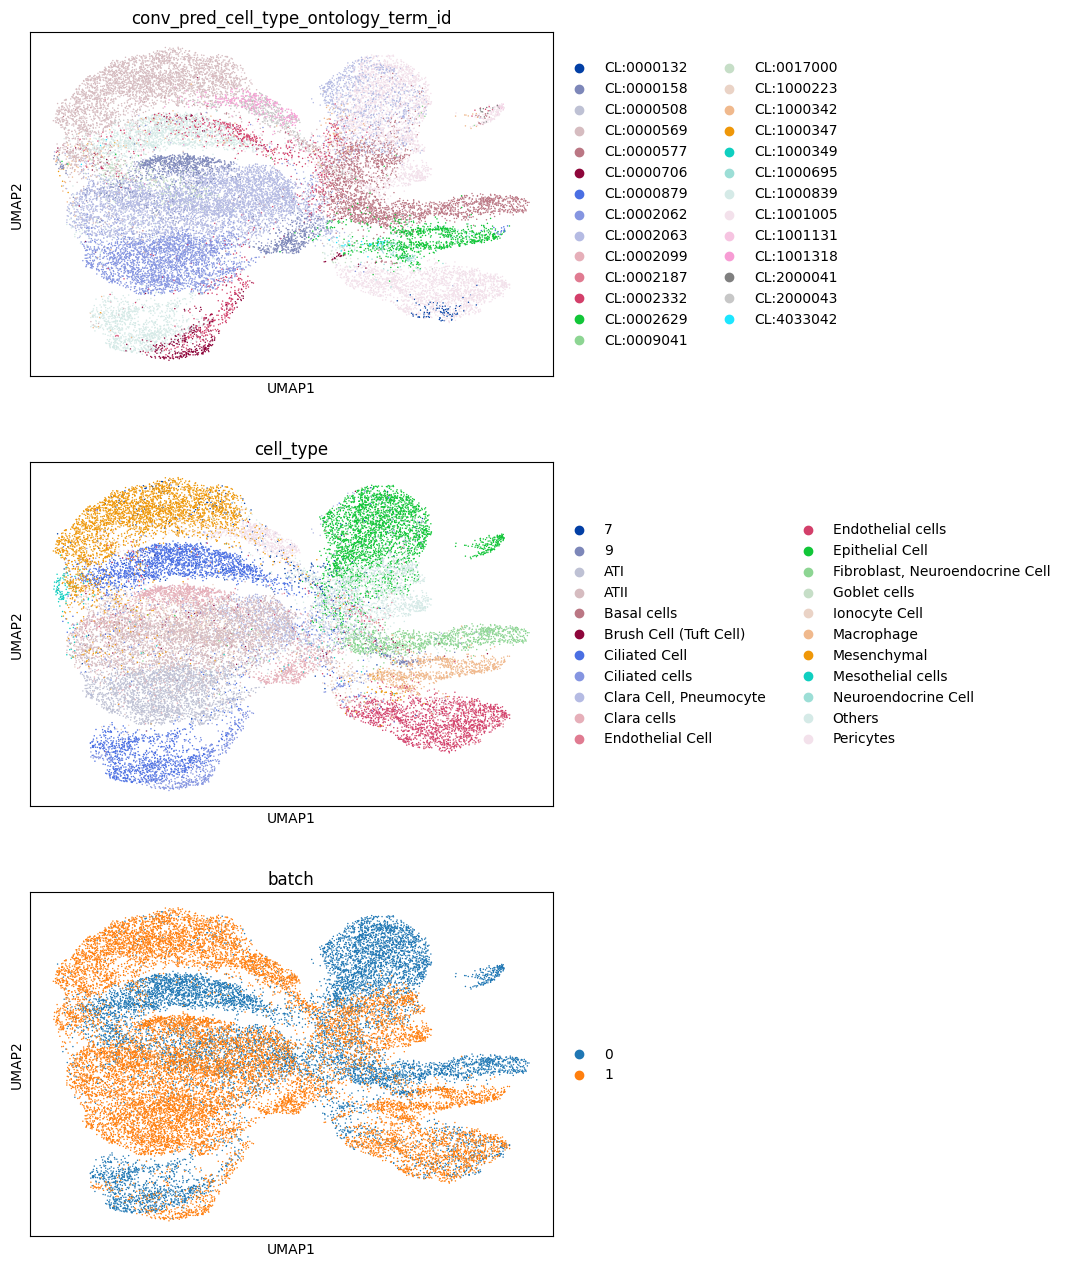

In [20]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

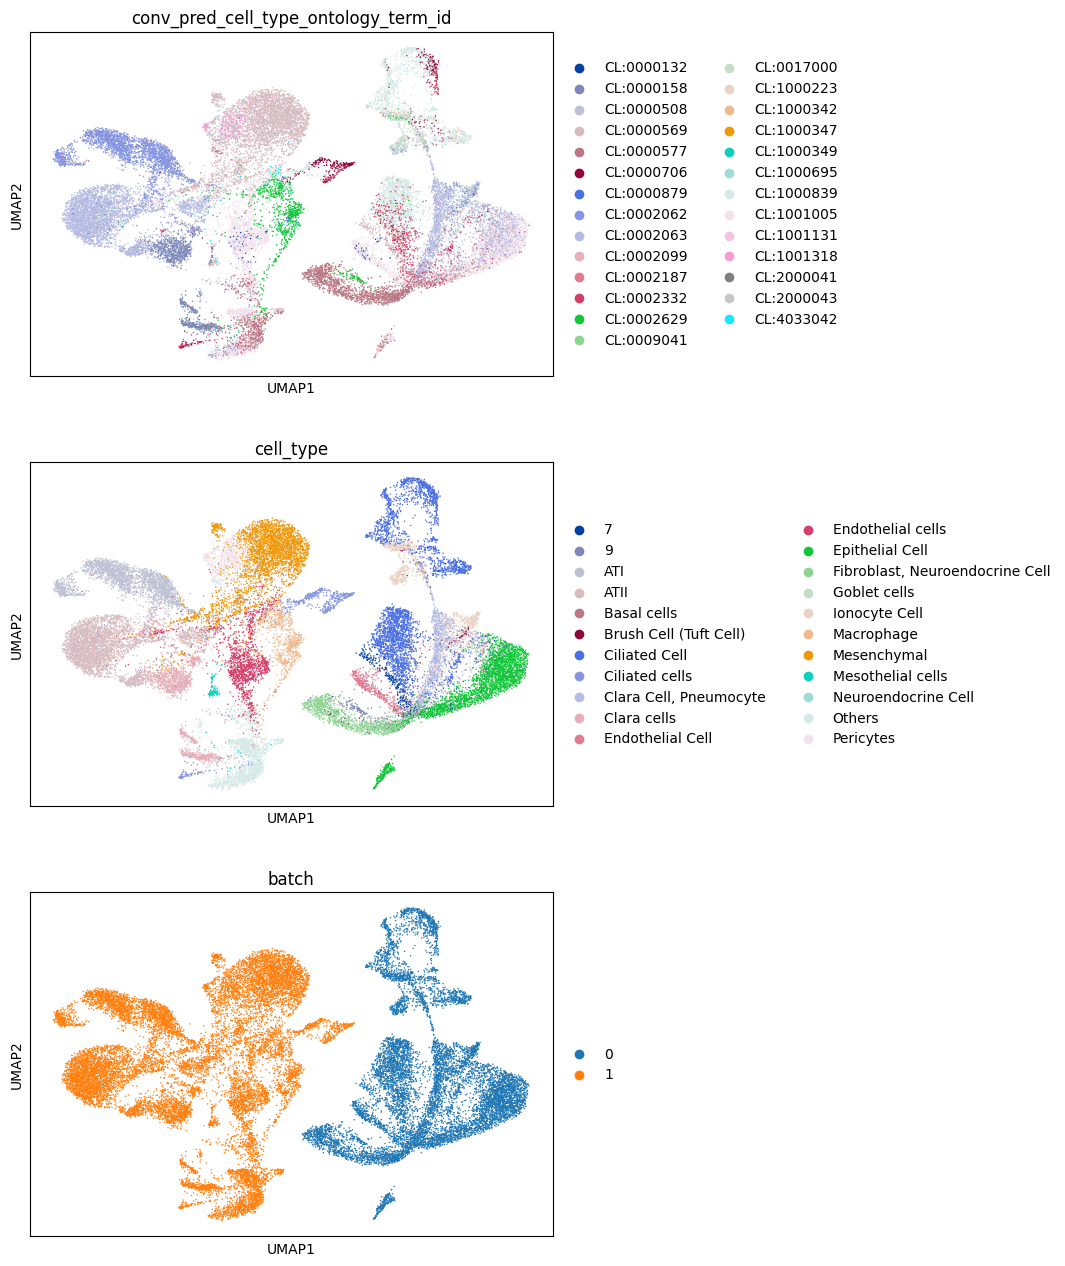

In [21]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

In [22]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="cell_type_ontology_term_id",  # celltype
    embedding_obsm_keys=["scprint_emb_cell_type_ontology_term_id"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=20,
)
bm.benchmark()

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


Computing neighbors:   0%|                                                                     | 0/1 [00:00<?, ?it/s]

Computing neighbors: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.97s/it]

Computing neighbors: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.97s/it]

Embeddings:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Metrics:   0%|                                                                                | 0/10 [00:00<?, ?it/s]

Metrics:   0%|                                             | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Wed Sep 10 18:32:19 2025 INFO isolated labels: no more than 1 batches per label


INFO:2025-09-10 18:32:19,747:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Wed Sep 10 18:32:19 2025 INFO Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Wed Sep 10 18:32:19 2025 WARNING An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Metrics:  10%|███▋                                 | 1/10 [00:47<07:03, 47.03s/it, Bio conservation: isolated_labels]

Metrics:  10%|██▎                    | 1/10 [00:47<07:03, 47.03s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|████▌                  | 2/10 [00:53<03:04, 23.05s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|███████▏                            | 2/10 [00:53<03:04, 23.05s/it, Bio conservation: silhouette_label]

Metrics:  30%|██████████▊                         | 3/10 [01:38<03:51, 33.04s/it, Bio conservation: silhouette_label]

Metrics:  30%|████████████▉                              | 3/10 [01:38<03:51, 33.04s/it, Bio conservation: clisi_knn]

Metrics:  40%|█████████████████▏                         | 4/10 [01:40<02:04, 20.74s/it, Bio conservation: clisi_knn]

Metrics:  40%|███████████████████▏                            | 4/10 [01:40<02:04, 20.74s/it, Batch correction: bras]

Metrics:  50%|████████████████████████                        | 5/10 [01:43<01:12, 14.57s/it, Batch correction: bras]

Metrics:  50%|█████████████████████▌                     | 5/10 [01:43<01:12, 14.57s/it, Batch correction: ilisi_knn]

Metrics:  60%|█████████████████████████▊                 | 6/10 [01:44<00:38,  9.73s/it, Batch correction: ilisi_knn]

Metrics:  60%|██████████████████████▊               | 6/10 [01:44<00:38,  9.73s/it, Batch correction: kbet_per_label]

INFO     CL:0000064 consists of a single batch or is too small. Skip.                                              


INFO     CL:0000066 consists of a single batch or is too small. Skip.                                              


INFO     CL:0000158 consists of a single batch or is too small. Skip.                                              


INFO     CL:0000165 consists of a single batch or is too small. Skip.                                              


INFO     CL:0000235 consists of a single batch or is too small. Skip.                                              


INFO     CL:0000322 consists of a single batch or is too small. Skip.                                              


INFO     CL:0000669 consists of a single batch or is too small. Skip.                                              


INFO     CL:0002062 consists of a single batch or is too small. Skip.                                              


INFO     CL:0002063 consists of a single batch or is too small. Skip.                                              


INFO     CL:0002204 consists of a single batch or is too small. Skip.                                              


INFO     CL:0005006 consists of a single batch or is too small. Skip.                                              


INFO     CL:0008019 consists of a single batch or is too small. Skip.                                              


Metrics:  70%|██████████████████████████▌           | 7/10 [01:50<00:26,  8.72s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████████████████████▊          | 7/10 [01:50<00:26,  8.72s/it, Batch correction: graph_connectivity]

/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|███████████████████████████▏      | 8/10 [01:50<00:11,  5.99s/it, Batch correction: graph_connectivity]

Metrics:  80%|██████████████████████████████▍       | 8/10 [01:50<00:11,  5.99s/it, Batch correction: pcr_comparison]

Metrics:  90%|██████████████████████████████████▏   | 9/10 [01:52<00:04,  4.52s/it, Batch correction: pcr_comparison]

Embeddings: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.13s/it]

Embeddings: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [01:52<00:00, 112.13s/it]

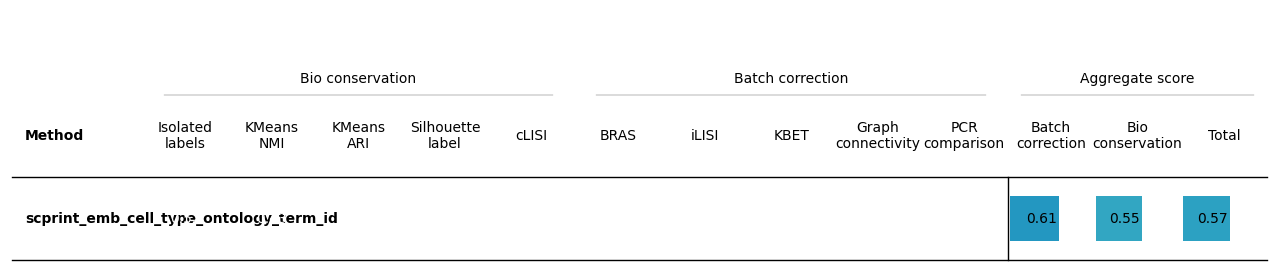

In [23]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)

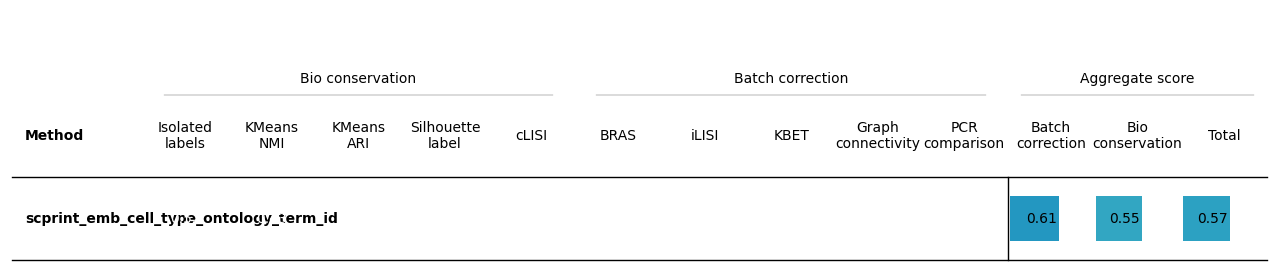

In [24]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)